In [1]:
# this sets up basic packages
import numpy as np
import pandas as pd
import astropy.units as u
import astropy.cosmology.units as cu

# this sets up matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# this sets up astropy
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord, skycoord_to_pixel
from astropy.utils.data import get_pkg_data_filename
from astropy.coordinates import SkyCoord, Angle, match_coordinates_sky, Distance

In [2]:
# this reads in the new neighbor catalog, originally made for CIGALE
df = pd.read_csv('post_correction_data.csv')

In [3]:
print('Before all the eliminations, there are a total of', df.shape[0], 'sources.')

Before all the eliminations, there are a total of 994 sources.


In [4]:
### now, look through the 9 QGs and their identified neighbors. do the same thing as we did earlier.
host_info = pd.read_csv('basic_data.txt', delimiter=' ', names=['name', 'RA', 'Dec', 'spec_z'])
host_ra_arr = host_info['RA'].values
host_dec_arr = host_info['Dec'].values
host_names = host_info['name'].values
how_many_galaxies = np.size(host_ra_arr)

# PRELIMINARY CHECK: CIGALE photo-z's and neighbor spec-z's if available

In [6]:
# this reads in the results FITS file that CIGALE made
cigale_results = fits.open('/Users/ngbinh/quenched/out_all998/results.fits')

In [7]:
# this gets the data from the results FITS file
cigale_data = Table(cigale_results[1].data).to_pandas()
cigale_data_2 = cigale_data.dropna(subset='bayes.universe.redshift')

In [8]:
# this gets only the rows that have spec-z
all_data = pd.read_csv('neighbor_data.csv')
all_data = all_data[all_data.duplicated(keep='first')==False]
all_data = all_data.dropna(subset='z_spec')

In [9]:
# this finds the IDs that overlap between the neighbors that have both photo-z in CIGALE's catalog
# and the ones that have spec-z in Hollis's catalog (hence the name 'both_ids' for this array)
both_ids = np.intersect1d(all_data['id'].values, cigale_data_2['id'].values)

In [10]:
relevant_spec_z = all_data.loc[all_data['id'].isin(both_ids)][['id', 'z_spec']]

In [11]:
relevant_photo_z = cigale_data_2.loc[cigale_data_2['id'].isin(both_ids)][['id', 'bayes.universe.redshift']]

In [12]:
both_sources = pd.merge(relevant_spec_z, relevant_photo_z, on='id', )

In [13]:
delta_z = both_sources['bayes.universe.redshift'].values - both_sources['z_spec'].values
sigma_nmad = 1.48 * np.median(np.abs((delta_z - np.median(delta_z)) / (1 + both_sources['z_spec'].values)))

In [14]:
sigma_nmad

0.09625073498281518

# CRITERION 1: Minimum of 3 detections, or less if there's A3COSMOS/ALMA data

In [16]:
# in a previous .csv file, all the neighbors are id'd based on their central galaxy.
# since this id is such a minor part of our work and isn't present in our later .csv or .txt files,
# we just retrieve these "our_id" values from the old .csv file, and then use them for our new work.
df2 = pd.read_csv('neighbor_data.csv')
df2 = df2[df2['id'].duplicated(keep='first')==False]
catalog_id = df2['id']
our_id = df2['our_id']
our_ra = df2['ra']
our_dec = df2['dec']
our_z = df2['z_spec']

In [17]:
# this opens the HDU list of the .fits catalog from A3COSMOS
hdu_list = fits.open('/Volumes/LaCie/COSMOS_DATA/a3cosmos_blind.fits')
hdu_list.info()

# this gets the data of the catalog
a3cosmos = hdu_list[1].data

Filename: /Volumes/LaCie/COSMOS_DATA/a3cosmos_blind.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      45   ()      
  1  J_ApJS_244_40_blind    1 BinTableHDU    115   1134R x 16C   [D, D, D, D, E, E, E, E, E, E, E, D, E, E, E, B]   


In [18]:
### matching coords from the A3COSMOS catalog using SkyCoord 
# create SkyCoord arrays (?) with the RA and Dec of the galaxies in both catalogs
radio_cat = SkyCoord(ra=a3cosmos['RAJ2000']*u.degree, dec=a3cosmos['DEJ2000']*u.degree)
spec_cat = SkyCoord(ra=our_ra.values*u.degree, dec=our_dec.values*u.degree)

# use search_around_sky to find matching indices (matching in RA and Dec) in each catalog
idx_radio, idx_spec, d2d, d3d = spec_cat.search_around_sky(radio_cat, 1*u.arcsec)

# use the matching indices to the new catalog to see where we have ground-based data of our neighbors
print(np.size(idx_radio), 'is the number of matches between the A3COSMOS and the spectroscopic catalogs.')

2 is the number of matches between the A3COSMOS and the spectroscopic catalogs.


In [19]:
# this calls the names of all the columns with flux measurements for all the galaxies
f_cols = [col for col in df.columns if '_err' not in col and col != 'id' and col != 'redshift']

In [20]:
# this saves all the neighbor ids that pass criterion 1
crit1_neigh_id = []

# this loops over all the galaxies from the .csv file, then reads their corresponding fluxes
# in all our bands to see if each of them has at least 3 different detections. if said galaxy does, 
# then we save the id of that galaxy, meaning that it passes criterion 1.

# this loops over each of the 9 QGs in our sample group
for id in catalog_id.values:
    
    # this retrieves all the corresponding fluxes of the galaxy with the id called
    all_bands = df[df['id'] == id][f_cols].values

    # this counts how many of these fluxes are non-zeros (i.e. how many detections there are)
    available_fluxes = np.count_nonzero(all_bands)

    # this adds the galaxy's id into crit1_neigh_id if the galaxy has more than 3 detections
    if available_fluxes >= 3:
        crit1_neigh_id.append(id)
        
print(len(crit1_neigh_id), 'is the total amount of neighbors that pass criterion 1.')

849 is the total amount of neighbors that pass criterion 1.


# CRITERION 2: |z$_{QG}$ - z$_{gal}$| < 0.5

In [22]:
# this selects only the rows in cigale_data and our_id
# whose corresponding source already passed criterion 1
reduced_cigale = cigale_data.loc[cigale_data['id'].isin(crit1_neigh_id)]
reduced_our_id = our_id[catalog_id.isin(crit1_neigh_id)]

In [23]:
cigale_id = reduced_cigale['id'].values
cigale_z = reduced_cigale['bayes.universe.redshift'].values
cigale_z_err = reduced_cigale['bayes.universe.redshift_err'].values

In [24]:
# now read in the RAs and Decs of our 9 galaxies to match them to Hollis's table
info = pd.read_csv('basic_data.txt', delimiter=' ', names=['name', 'RA', 'Dec', 'spec_z'])
galaxy_redshift = info['spec_z'].values

In [25]:
# this saves all the neighbor ids that pass criterion 2, along with the RAs and Decs of their neighbors
crit2_neigh_id = []

all_values = []

# this loops over each of the 9 QGs in our sample group
for our_galaxy in range(np.size(galaxy_redshift)):
    # this selects the neighbor IDs, ONLY the ones that passed criterion 1
    neigh_id = np.array(cigale_id[reduced_our_id==our_galaxy])

    # this reads in the estimated z and errors of all the neighbors around each galaxy that passed criterion 1
    neigh_z = np.array(cigale_z[reduced_our_id==our_galaxy])
    neigh_z_err = np.array(cigale_z_err[reduced_our_id==our_galaxy])

    # this sets criterion 2
    criteria = (np.abs(neigh_z + neigh_z_err - galaxy_redshift[our_galaxy]) <= 0.5) | (np.abs(neigh_z - neigh_z_err - galaxy_redshift[our_galaxy]) <= 0.5)

    # this finds neighbor IDs that pass criterion 2
    ok_neigh_id = neigh_id[criteria]

    # this saves the indices of the neighbors that pass criterion 2
    crit2_neigh_id.extend(ok_neigh_id)

print(len(crit2_neigh_id), 'is the total amount of neighbors that pass criterion 2.')

233 is the total amount of neighbors that pass criterion 2.


Now, we save the plots of the fits that passed both criteria altogether into a separate .pdf file.

In [27]:
import PyPDF2, os

In [28]:
pdfiles = []
for filename in os.listdir('/Users/ngbinh/quenched/out_all998'):
    if filename[0:6] in str(crit2_neigh_id) and filename.endswith('.pdf'):
        if filename != 'merged.pdf':
            pdfiles.append(filename)
                        
pdfiles.sort(key = str.lower)

In [29]:
pdfMerge = PyPDF2.PdfMerger()
for filename in pdfiles:
    pdfFile = open('/Users/ngbinh/quenched/out_all998/' + filename, 'rb')
    pdfReader = PyPDF2.PdfReader(pdfFile)
    pdfMerge.append(pdfReader)
pdfFile.close()
pdfMerge.write('merged.pdf')

# Miscellaneous Eliminations of Bad Fits

First, compare our new sample to our old sample, where there are 160 potential neighbors (see the notebook named <b>eliminate_neighbors_old_data.ipynb</b>). We're doing this just to see how much our two samples differ from one another.

In [32]:
# this reads in the .txt file where we've saved the indices of the potential neighbors
old_potential = np.genfromtxt('/Users/ngbinh/quenched_trash/no longer relevant/old_data_potential_neighbors.txt', dtype=('float','f8'))

In [33]:
# this converts crit2_neigh_id into an array of floats so it's easier to compare
new_potential = np.array(crit2_neigh_id, dtype=('float','f8'))

In [34]:
# this is to find how many common elements are in both arrays
common = np.intersect1d(old_potential, new_potential)

In [35]:
# this reads in the old results file
cigale_old = fits.open('/Users/ngbinh/quenched_trash/out_all 2.35.35 PM/results.fits')
cigale_old.info()

# this gets the data from the old results file
cigale_old_table = Table(cigale_old[1].data).to_pandas()

# this locates the common potential neighbors in the old results file
info_cigale_old = cigale_old_table.loc[cigale_old_table['id'].isin(common)]

Filename: /Users/ngbinh/quenched_trash/out_all 2.35.35 PM/results.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU    386   994R x 127C   [K, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   


In [36]:
# this locates the common potential neighbors in the new results file
info_cigale_new = cigale_data.loc[cigale_data['id'].isin(common)]

<>:19: SyntaxWarning: invalid escape sequence '\o'
<>:19: SyntaxWarning: invalid escape sequence '\o'
/var/folders/td/xh27mb7x6jz3g1splvmtw7z80000gn/T/ipykernel_3190/92395639.py:19: SyntaxWarning: invalid escape sequence '\o'
  ax[2].set_title('log$_{10}$(M$_*$/M$_\odot$)')


Text(0, 0.5, 'new')

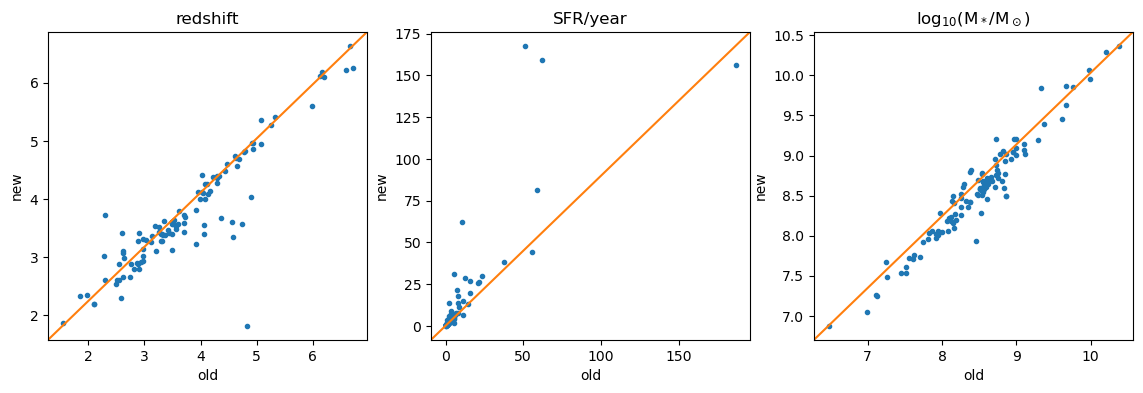

In [37]:
# now we make some diagnostic plots to compare the old and new results
# (only looking at the common potential neighbors in both samples)

fig, ax = plt.subplots(1, 3, figsize=(14, 4))
ax[0].plot(info_cigale_old['bayes.universe.redshift'].values, info_cigale_new['bayes.universe.redshift'].values, '.')
ax[0].plot([0, 1], [0, 1], transform=ax[0].transAxes)
ax[0].set_title('redshift')
ax[0].set_xlabel('old')
ax[0].set_ylabel('new')

ax[1].plot(info_cigale_old['bayes.sfh.sfr'].values, info_cigale_new['bayes.sfh.sfr'].values, '.')
ax[1].plot([0, 1], [0, 1], transform=ax[1].transAxes)
ax[1].set_title('SFR/year')
ax[1].set_xlabel('old')
ax[1].set_ylabel('new')

ax[2].plot(np.log10(info_cigale_old['bayes.stellar.m_star'].values), np.log10(info_cigale_new['bayes.stellar.m_star'].values), '.')
ax[2].plot([0, 1], [0, 1], transform=ax[2].transAxes)
ax[2].set_title('log$_{10}$(M$_*$/M$_\odot$)')
ax[2].set_xlabel('old')
ax[2].set_ylabel('new')

From these plots, we see that the new fits and the old fits are essentially the same, meaning there's no need to reanalyze the potential neighbors selected from the old sample. Since we already saved the IDs of the good fits selected from the old sample, we'll just use that list.

In [39]:
# this reads in the .txt file where we've saved the indices of the potential 
# neighbors with good fits, as selected from the old sample
old_good_fits_idx = np.genfromtxt('old_good_fits.txt', dtype=('float','f8'))

# now, we pick out the ones that are good fits and are also common between the old and new samples
good_fits_1 = np.intersect1d(common, old_good_fits_idx)

In [40]:
# this takes the data of all the new fits based on the indices from the old good fits
good_fits_from_old = cigale_data.loc[cigale_data['id'].isin(good_fits_1)]

Next, we visually inspect the neighbors that did not appear in our old sample.

In [42]:
# we pick out the IDs of the new fits
other_new_fits = np.setdiff1d(new_potential, common)

In [43]:
# now, we make a PDF file of all the plots of the new fits. this is so that it's easier to visually inspect them all
import PyPDF2, os

pdfiles = []
for filename in os.listdir('/Users/ngbinh/quenched/out_all998/'):
    if filename[0:6] in str(other_new_fits) and filename.endswith('.pdf'):
        pdfiles.append(filename)
                        
pdfiles.sort(key = str.lower)

pdfMerge = PyPDF2.PdfMerger()
for filename in pdfiles:
    pdfFile = open('/Users/ngbinh/quenched/out_all998/' + filename, 'rb')
    pdfReader = PyPDF2.PdfReader(pdfFile)
    pdfMerge.append(pdfReader)
pdfFile.close()
pdfMerge.write('all_new_fits.pdf')

After making a list of visually inspected bad fits, we pick out the good fits and save them.

In [45]:
# this reads in the .txt file where we've saved the indices of the bad fits
new_bad_fits_idx = np.genfromtxt('new_bad_fits.txt', dtype=('float','f8'))

# now, we pick out the ones that are not "bad fits", and are also common between the old and new samples
# NOTE that these aren't necessary "good fits". there are some fits that we're unable to visually inspect
# because CIGALE can't plot them for some reason. for those ones, we'll just discard the fits.
other_fits = np.setdiff1d(other_new_fits, new_bad_fits_idx)

In [46]:
# now, we make a PDF file of all the plots of the new fits. this is so that it's easier to visually inspect them all
import PyPDF2, os

# this creates a secondary list that saves only the IDs of the non-bad fits that have plots 
# which we've visually inspected--i.e. fits that have been confirmed to be good.
good_fits_2 = []

pdfiles = []
for filename in os.listdir('/Users/ngbinh/quenched/out_all998/'):
    if filename[0:6] in str(other_fits) and filename.endswith('.pdf'):
        pdfiles.append(filename)

        # this saves the names of only the fits that are non-bad and have plots which
        # we've visually inspected, i.e. fits we've confirmed to be good
        good_fits_2.append(float(filename[0:6]))
                        
pdfiles.sort(key = str.lower)

pdfMerge = PyPDF2.PdfMerger()
for filename in pdfiles:
    pdfFile = open('/Users/ngbinh/quenched/out_all998/' + filename, 'rb')
    pdfReader = PyPDF2.PdfReader(pdfFile)
    pdfMerge.append(pdfReader)
pdfFile.close()
pdfMerge.write('good_fits.pdf')

In [47]:
good_fits_2 = np.array(good_fits_2, dtype='object')

In [48]:
# now, make an array of all the good fits
all_good_fits = np.concatenate((good_fits_1, good_fits_2))

In [49]:
# retrieve all the relevant info for the good fits from CIGALE's data table
info_good_fits = cigale_data.loc[cigale_data['id'].isin(all_good_fits)] # candi: short for candidate

In [50]:
info_good_fits['id'].values

array([756228, 756324, 756381, 756542, 756650, 756791, 756809, 756895,
       756931, 780235, 780261, 780365, 780483, 780489, 780511, 780592,
       780808, 780830, 780870, 780882, 780995, 781053, 781056, 757782,
       757931, 757934, 757952, 757967, 758035, 758076, 758096, 758165,
       782619, 782740, 782969, 783186, 783189, 783202, 783240, 804680,
       804711, 830212, 830422, 830622, 756960, 756994, 757025, 757035,
       757177, 757208, 757258, 757350, 757396, 757532, 780960, 781069,
       781337, 781608, 781836, 781863, 758845, 758998, 759022, 759045,
       759140, 759202, 759207, 759298, 759334, 759455, 759460, 759545,
       759592, 759715, 783764, 783888, 783941, 783964, 784079, 784159,
       784266, 784406, 784483, 784557, 784569, 784580, 784614, 784646,
       784663, 614117, 614284, 614318, 614521, 614660, 641810, 642465,
       642503, 614192, 661790, 661825, 661910, 662039, 662092, 683386,
       659472, 659600, 659694, 659753, 659914, 680426, 680812, 757887,
      

# Searching for Quenched Neighbors

Now, let's calculate the specific star formation rate (sSFR) of all the good-fit galaxies to see which ones are quenched. 

The equation for sSFR is as follows for each galaxy:
$$
sSFR=log_{10}(\frac{SFR}{M_*})
$$
For our intents and purposes, a galaxy is quenched if <b>sSFR < -9.8</b>.

In [53]:
# calculate sSFR. "all_candis" means "all candidates". I'm just too lazy to spell it all out.
ssfr_all_candis_bayes = np.log10(info_good_fits['bayes.sfh.sfr'].values / info_good_fits['bayes.stellar.m_star'].values)
ssfr_all_candis_best = np.log10(info_good_fits['best.sfh.sfr'].values / info_good_fits['best.stellar.m_star'].values)

In [54]:
max(ssfr_all_candis_bayes)

-7.619118137380776

Text(0, 0.5, 'amount')

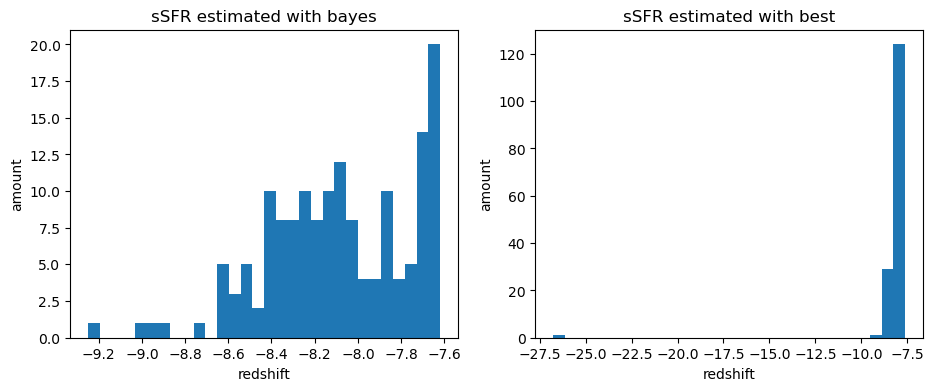

In [55]:
# now we make two histograms to compare how many quenched neighbors are identified with either bayes or best
fig, ax = plt.subplots(1, 2, figsize=(11, 4))
ax[0].hist(ssfr_all_candis_bayes, bins=30)
ax[0].set_title('sSFR estimated with bayes')
ax[0].set_xlabel('redshift')
ax[0].set_ylabel('amount')

ax[1].hist(ssfr_all_candis_best, bins=30)
ax[1].set_title('sSFR estimated with best')
ax[1].set_xlabel('redshift')
ax[1].set_ylabel('amount')

In [56]:
info_good_fits

,id,bayes.attenuation.E_BVs,bayes.attenuation.E_BVs_err,bayes.sfh.age_main,bayes.sfh.age_main_err,bayes.universe.redshift,bayes.universe.redshift_err,bayes.sfh.sfr,bayes.sfh.sfr_err,bayes.sfh.sfr100Myrs,...,best.subaru.suprime.IB427,best.subaru.suprime.IB505,best.subaru.suprime.IB574,best.subaru.suprime.IB709,best.subaru.suprime.IB827,best.subaru.suprime.NB711,best.subaru.suprime.NB816,best.spitzer.irac.ch1,best.spitzer.irac.ch2,best.spitzer.irac.ch3
0,756228,0.088857,0.035769,417.624948,354.005857,3.278320,0.525038,3.558649,1.834240,2.915679,...,1.467487e-05,3.040419e-05,0.000063,0.000065,0.000071,0.000065,0.000071,1.196896e-04,1.428054e-04,1.476414e-04
2,756324,0.142144,0.081505,526.144334,365.795022,3.136364,0.510097,3.385109,2.849470,2.944019,...,1.228186e-05,4.935640e-05,0.000037,0.000043,0.000043,0.000043,0.000043,1.022433e-04,1.066111e-04,1.009454e-04
5,756381,0.089931,0.002999,100.658272,22.407275,3.601789,0.055604,7.290918,0.364546,3.845178,...,1.186805e-05,5.654811e-05,0.000117,0.000121,0.000124,0.000120,0.000124,1.232406e-04,1.542069e-04,1.061178e-04
14,756542,0.249534,0.008622,100.170514,11.594269,4.401081,0.286135,13.469845,1.298317,7.477333,...,-3.560853e-10,3.060166e-07,0.000010,0.000035,0.000041,0.000036,0.000041,1.587561e-04,9.742184e-05,1.379322e-04
19,756650,0.450849,0.021279,100.002315,1.087818,3.599899,0.021833,19.724432,1.713810,10.549690,...,3.704218e-07,3.433116e-06,0.000009,0.000013,0.000015,0.000013,0.000015,1.311768e-04,2.264904e-04,1.855936e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,823998,0.006525,0.019346,484.234110,417.265533,4.258428,0.979942,1.457550,0.721397,1.414571,...,0.000000e+00,0.000000e+00,0.000003,0.000013,0.000060,0.000012,0.000060,2.368231e-05,3.938737e-05,2.702594e-05
981,824034,0.006721,0.016807,497.113674,337.545777,2.540534,0.277544,0.228684,0.087718,0.219566,...,1.675115e-05,1.766437e-05,0.000017,0.000017,0.000016,0.000017,0.000017,1.841179e-05,1.685075e-05,1.723205e-05
983,824065,0.014784,0.028866,334.670839,336.738491,3.015252,0.670935,0.487810,0.221449,0.374835,...,5.108543e-06,1.824325e-05,0.000030,0.000026,0.000024,0.000026,0.000024,1.584817e-05,2.062088e-05,1.368695e-05
986,824112,0.000951,0.006105,141.500567,319.473322,2.640952,0.979775,0.037928,0.020141,0.023401,...,6.570203e-07,2.140676e-06,0.000003,0.000003,0.000002,0.000003,0.000002,9.138732e-07,9.695734e-07,7.496797e-07


# Exporting a Final DataFrame

Now, we make one FINAL DataFrame with all our potential neighbors. We also retrieve their RA and Dec from the original <b>neighbor_data.csv</b> file.


In [58]:
# these lines retrieve their RA and Dec from the original neighbor_data.csv file
good_fits_ra = df2[['id', 'ra']].loc[catalog_id.isin(info_good_fits['id'].values)]
good_fits_dec = df2[['id', 'dec']].loc[catalog_id.isin(info_good_fits['id'].values)]

In [59]:
# this creates a DataFrame with the RA and Dec of our good-fits neighbors
good_fits_df = pd.merge(pd.merge(info_good_fits, good_fits_ra, on="id", how="left"), good_fits_dec, on="id", how="left")

In [60]:
final_df = good_fits_df[['id', 'ra', 'dec', 'bayes.universe.redshift', 'bayes.universe.redshift_err', 
                         'bayes.stellar.m_star', 'bayes.stellar.m_star_err', 'bayes.sfh.sfr', 
                         'bayes.sfh.sfr_err', 'bayes.sfh.sfr100Myrs', 'bayes.sfh.sfr100Myrs_err', 
                         'bayes.attenuation.E_BVs', 'bayes.attenuation.E_BVs_err']]

## <b>BEHOLD!</b> Our final table!

## NOTES: Aug 20, 2024.<br>
### formatting stuff for our table:<br>
### M*: log10(mass) $\pm$ (0.434$\frac{uncertainty}{mass}$)<br>
### SFR: leave NO decimal
### z$_{phot}$: leave one significant figure (tenth decimal), same for error
### RA, Dec: follow form 00:00:00.00 (use code)
### log10(specific SFR) where Specific SFR = $\frac{SFR}{M*}$ and follows form "-8.2" or "-12"
### in cases where specific SFR < -12, just say "< -12".
### in cases where SFR is beyond one decimal point (0.03) then write 0. maybe note this down.

In [63]:
# Oct 24: add a column indicating angular separation. this requires loading in a specific .csv file
sorted = pd.read_csv('all_neighbors.csv')
sorted = sorted.fillna('NA')

In [64]:
sorted

,id,ra,dec,host_ra,host_dec,host_name,our_id,nbr_name
0,756228,150.061200,2.374627,150.061490,2.378680,Hong,0,Hong HX1
1,756324,150.062186,2.375231,150.061490,2.378680,Hong,0,Hong HX2
2,756381,150.058607,2.377135,150.061490,2.378680,Hong,0,Hong HX3
3,756542,150.064461,2.376458,150.061490,2.378680,Hong,0,Hong HX4
4,756791,150.062122,2.379950,150.061490,2.378680,Hong,0,Hong HX5
...,...,...,...,...,...,...,...,...
150,823362,150.110016,2.327140,150.108873,2.330539,NA,8,NA
151,823454,150.108507,2.328465,150.108873,2.330539,NA,8,NA
152,823493,150.109905,2.328249,150.108873,2.330539,NA,8,NA
153,823724,150.111572,2.329369,150.108873,2.330539,NA,8,NA


In [65]:
mega_df = pd.merge(final_df[['id', 'bayes.stellar.m_star', 'bayes.sfh.sfr', 'bayes.universe.redshift', 
                             'bayes.universe.redshift_err', 'bayes.stellar.m_star_err', 'bayes.sfh.sfr_err']], sorted, on='id', how='right')

In [66]:
# this saves the RA and Dec into 00:00:00.00 format, which we'll then use for our LaTeX table.
# the code was copy-pasted from Arianna, of course.
save_coords = SkyCoord(mega_df['ra'].values*u.deg, mega_df['dec'].values*u.deg)
ras = []
decs = []
for i in zip(save_coords.ra.hms[0], save_coords.ra.hms[1],save_coords.ra.hms[2]):
    if (len(str(round(i[2],2))) >= 5):
        ras.append(str(round(i[0])).zfill(2)+':'+str(round(i[1])).zfill(2)+':'+str(round(i[2],2)).zfill(4))
    elif ((len(str(round(i[2],2))) == 4) & (round(i[2],2) < 10)):
        ras.append(str(round(i[0])).zfill(2)+':'+str(round(i[1])).zfill(2)+':'+str(round(i[2],2)).zfill(5))
    else:
        ras.append(str(round(i[0])).zfill(2)+':'+str(round(i[1])).zfill(2)+':'+str(round(i[2],2)).zfill(4))
for i in zip(save_coords.dec.dms[0], save_coords.dec.dms[1],save_coords.dec.dms[2]):
    if (len(str(round(i[2],2))) >= 5):
        decs.append('$+$'+str(round(i[0])).zfill(2)+':'+str(round(i[1])).zfill(2)+':'+str(round(i[2],2)).zfill(4))
    elif ((len(str(round(i[2],2))) == 4) & (round(i[2],2) < 10)):
        decs.append('$+$'+str(round(i[0])).zfill(2)+':'+str(round(i[1])).zfill(2)+':'+str(round(i[2],2)).zfill(5))
    else:
        decs.append('$+$'+str(round(i[0])).zfill(2)+':'+str(round(i[1])).zfill(2)+':'+str(round(i[2],2)).zfill(4))

In [67]:
# first, this makes a TXT file of the good fits to send to Erini
f = open('good_fits_ra_dec.txt', 'w')
for i in range(np.size(ras)):
    each_line = str(mega_df['id'].values[i]) + ' ' + str(ras[i]) + ' +' + str(decs[i][3:]) + '\n'
    f.write(each_line)

f.close()

In [68]:
# this saves the rest of the necessary data to use for the LaTeX table
host_name = []

catalog_ids = mega_df['id'].values
nbr_names = mega_df['nbr_name'].values
name_list = []

photz_values = np.round(mega_df['bayes.universe.redshift'].values, 1)
photz_errors_unrounded = mega_df['bayes.universe.redshift_err'].values
photz = []

mass_values = np.round(np.log10(mega_df['bayes.stellar.m_star'].values), 1)
mass_errors_unrounded = 0.434 * mega_df['bayes.stellar.m_star_err'].values / mega_df['bayes.stellar.m_star'].values
mass = []

sfr_values = np.int64(mega_df['bayes.sfh.sfr'].values)
sfr_errors_unrounded = mega_df['bayes.sfh.sfr_err'].values
sfr = []

nbr_coords = mega_df[['ra', 'dec']].values
host_coords = mega_df[['host_ra', 'host_dec']].values
theta = []

ssfr_calc = np.log10(mega_df['bayes.sfh.sfr'].values / mega_df['bayes.stellar.m_star'].values)
ssfr = []

# this loops over all the rows of mega_df and reformulates them
for all_idx in range(np.size(mega_df['id'].values)):

    ### HOST NAME
    host_our_id = mega_df['our_id'].values[all_idx]
    host_name.append(host_names[host_our_id])
    
    ### NEIGHBOR NAME/ID
    if nbr_names[all_idx] != 'NA':
        name_list.append(nbr_names[all_idx])
    else:
        name_list.append(str(catalog_ids[all_idx]))
    
    ### PHOTOMETRIC REDSHIFT
    photz_err = photz_errors_unrounded[all_idx]
    # this checks to see if the redshift error is too close to 0. then we round it up to 0.1.
    if np.abs(0.1 - photz_err) > photz_err:
        photz.append(str(photz_values[all_idx]) + ' $' + chr(92) + 'pm$ ' + str(0.1))
    else:
        photz_err_rounded = np.round(photz_err, 1)
        photz.append(str(photz_values[all_idx]) + ' $' + chr(92) + 'pm$ ' + str(photz_err_rounded))

    ### STELLAR MASS
    mass_err = mass_errors_unrounded[all_idx]
    # this checks to see if the mass error is too close to 0. then we round it up to 0.1.
    if np.abs(0.1 - mass_err) > mass_err:
        mass.append(str(mass_values[all_idx]) + ' $' + chr(92) + 'pm$ ' + str(0.1))
    else:
        mass_err_rounded = np.round(mass_err, 1)
        mass.append(str(mass_values[all_idx]) + ' $' + chr(92) + 'pm$ ' + str(mass_err_rounded))

    ### STAR FORMATION RATE
    sfr_err = sfr_errors_unrounded[all_idx]
    # this checks for cases like '0 +- 1'
    if sfr_values[all_idx] == 0 and sfr_err > 0 and sfr_err < 1:
        sfr.append('$<$ 1')
    # this checks to see if the SFR error is too close to 0. then we round it up to 1.
    elif sfr_values[all_idx] != 0 and sfr_err > 0 and sfr_err < 1:
        sfr.append(str(sfr_values[all_idx]) + ' $' + chr(92) + 'pm$ ' + str(1))
    else:
        sfr_err_rounded = np.int64(sfr_err)
        sfr.append(str(sfr_values[all_idx]) + ' $' + chr(92) + 'pm$ ' + str(sfr_err_rounded))

    ### SPECIFIC STAR FORMATION RATE
    ssfr_value = ssfr_calc[all_idx]
    ssfr.append('$-$' + str(np.round(np.abs(ssfr_value), 1)))

    ### ANGULAR SEPARATION
    nbr_coords = SkyCoord(ra=mega_df['ra'].values[all_idx]*u.degree, dec=mega_df['dec'].values[all_idx]*u.degree)
    host_coords = SkyCoord(ra=mega_df['host_ra'].values[all_idx]*u.degree, dec=mega_df['host_dec'].values[all_idx]*u.degree)
    separation = host_coords.separation(nbr_coords).to(u.arcsec)
    theta.append(str(np.round(separation.value, 2)))

In [69]:
latex_table = {'Host': host_name, 'Neighbor name': name_list, 'R.A.': ras, 'Decl.': decs, 'z$_{phot}$': photz, 
               'log$_{10}$(M$_*$/M$_\odot$)': mass, 'SFR(M$_*$/yr)': sfr, 'log$_{10}$(sSFR/yr)': ssfr, '$\theta_{sep} (")$': theta}
latex = pd.DataFrame(latex_table)

<>:2: SyntaxWarning: invalid escape sequence '\o'
<>:2: SyntaxWarning: invalid escape sequence '\o'
/var/folders/td/xh27mb7x6jz3g1splvmtw7z80000gn/T/ipykernel_3190/2935413583.py:2: SyntaxWarning: invalid escape sequence '\o'
  'log$_{10}$(M$_*$/M$_\odot$)': mass, 'SFR(M$_*$/yr)': sfr, 'log$_{10}$(sSFR/yr)': ssfr, '$\theta_{sep} (")$': theta}


In [70]:
latex

,Host,Neighbor name,R.A.,Decl.,z$_{phot}$,log$_{10}$(M$_*$/M$_\odot$),SFR(M$_*$/yr),log$_{10}$(sSFR/yr),"$\theta_{sep} ("")$"
0,Hong,Hong HX1,10:00:14.69,$+$02:22:28.66,3.3 $\pm$ 0.5,8.6 $\pm$ 0.2,3 $\pm$ 1,$-$8.1,14.63
1,Hong,Hong HX2,10:00:14.92,$+$02:22:30.83,3.1 $\pm$ 0.5,8.7 $\pm$ 0.2,3 $\pm$ 2,$-$8.1,12.67
2,Hong,Hong HX3,10:00:14.07,$+$02:22:37.69,3.6 $\pm$ 0.1,8.5 $\pm$ 0.1,7 $\pm$ 1,$-$7.6,11.77
3,Hong,Hong HX4,10:00:15.47,$+$02:22:35.25,4.4 $\pm$ 0.3,8.8 $\pm$ 0.1,13 $\pm$ 1,$-$7.7,13.35
4,Hong,Hong HX5,10:00:14.91,$+$02:22:47.82,3.4 $\pm$ 0.1,8.8 $\pm$ 0.2,4 $\pm$ 1,$-$8.2,5.11
...,...,...,...,...,...,...,...,...,...
150,Tien,823362,10:00:26.4,$+$02:19:37.7,4.4 $\pm$ 1.1,8.6 $\pm$ 0.2,1 $\pm$ 1,$-$8.4,12.91
151,Tien,823454,10:00:26.04,$+$02:19:42.48,2.3 $\pm$ 0.6,7.5 $\pm$ 0.2,$<$ 1,$-$8.2,7.58
152,Tien,823493,10:00:26.38,$+$02:19:41.69,4.0 $\pm$ 0.4,8.2 $\pm$ 0.2,1 $\pm$ 1,$-$8.2,9.04
153,Tien,823724,10:00:26.78,$+$02:19:45.73,2.6 $\pm$ 0.6,8.2 $\pm$ 0.2,$<$ 1,$-$8.3,10.58


In [71]:
print(latex.to_latex(index=False))

\begin{tabular}{lllllllll}
\toprule
Host & Neighbor name & R.A. & Decl. & z$_{phot}$ & log$_{10}$(M$_*$/M$_\odot$) & SFR(M$_*$/yr) & log$_{10}$(sSFR/yr) & $	heta_{sep} (")$ \\
\midrule
Hong & Hong HX1 & 10:00:14.69 & $+$02:22:28.66 & 3.3 $\pm$ 0.5 & 8.6 $\pm$ 0.2 & 3 $\pm$ 1 & $-$8.1 & 14.63 \\
Hong & Hong HX2 & 10:00:14.92 & $+$02:22:30.83 & 3.1 $\pm$ 0.5 & 8.7 $\pm$ 0.2 & 3 $\pm$ 2 & $-$8.1 & 12.67 \\
Hong & Hong HX3 & 10:00:14.07 & $+$02:22:37.69 & 3.6 $\pm$ 0.1 & 8.5 $\pm$ 0.1 & 7 $\pm$ 1 & $-$7.6 & 11.77 \\
Hong & Hong HX4 & 10:00:15.47 & $+$02:22:35.25 & 4.4 $\pm$ 0.3 & 8.8 $\pm$ 0.1 & 13 $\pm$ 1 & $-$7.7 & 13.35 \\
Hong & Hong HX5 & 10:00:14.91 & $+$02:22:47.82 & 3.4 $\pm$ 0.1 & 8.8 $\pm$ 0.2 & 4 $\pm$ 1 & $-$8.2 & 5.11 \\
Hong & Hong HX6 & 10:00:14.89 & $+$02:22:48.23 & 3.6 $\pm$ 0.2 & 9.2 $\pm$ 0.1 & 1 $\pm$ 1 & $-$8.9 & 5.36 \\
Hong & Hong HX7 & 10:00:14.71 & $+$02:22:53.56 & 3.7 $\pm$ 0.2 & 9.2 $\pm$ 0.1 & 6 $\pm$ 3 & $-$8.4 & 10.33 \\
Hong & Hong HX8 & 10:00:14.27 & $+$02:2

In [72]:
final_df = final_df.assign(host_ra = info['RA'].values[df2[df2['id'].isin(final_df['id'].values)]['our_id'].values].tolist())
final_df = final_df.assign(host_dec = info['Dec'].values[df2[df2['id'].isin(final_df['id'].values)]['our_id'].values].tolist())

In [73]:
# now, save a simplified .txt files to make postage stamps
final_df[['id', 'ra', 'dec', 'host_ra', 'host_dec']].to_csv('potential_neighbors.txt', sep='\t', index=False)

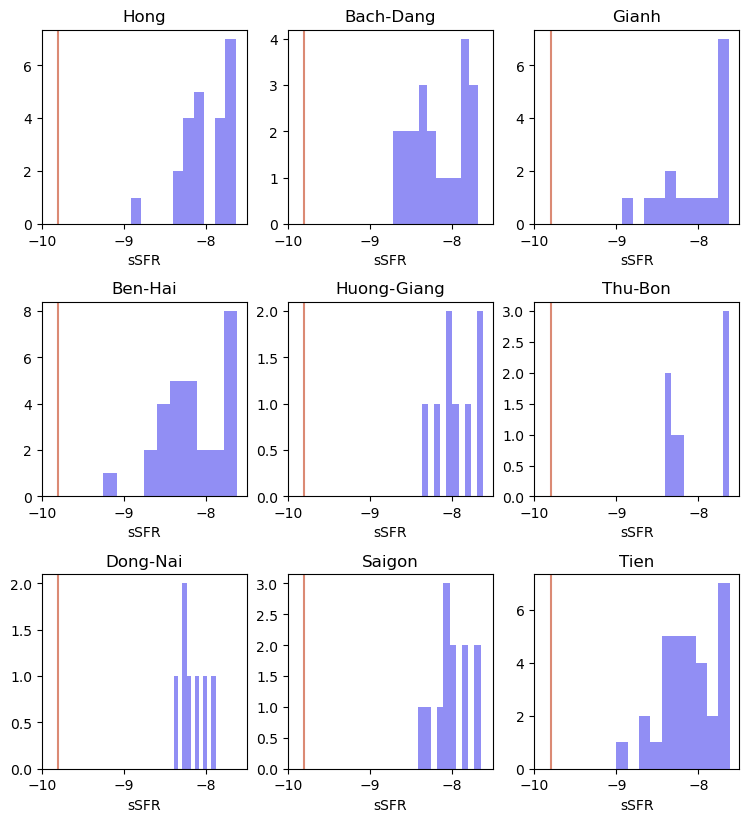

In [74]:
# Set number of columns
ncols = 3
# Calculate number of rows
nrows = 3

fig = plt.figure()
fig.set_figwidth(ncols*3)
fig.set_figheight(nrows*3.2)

### This makes sure the subplots are close together.
fig.subplots_adjust(wspace=0.2, hspace=0.4)

for galaxy_number in range(how_many_galaxies):
    
    # this retrieves the RA and Dec of each QG
    host_ra = host_ra_arr[galaxy_number]
    host_dec = host_dec_arr[galaxy_number]    
    host_name = host_names[galaxy_number]

    # this gets the row that has the info of all the relevant neighbors
    tentatives = final_df[final_df['host_ra']==host_ra]

    # this gets the sSFRs of all the relevant neighbors
    sSFR_tentatives = np.log10(tentatives['bayes.sfh.sfr'].values / tentatives['bayes.stellar.m_star'].values)

    ax = plt.subplot(ncols, nrows, galaxy_number+1)
    ax.hist(sSFR_tentatives, color='#918EF4')
    ax.axvline(x=-9.8, color='#DB8A74')
    ax.set_title(host_name)
    ax.set_xlim(left=-10, right=-7.5)
    ax.set_xlabel('sSFR')

fig.savefig('sSFR-histograms-9QGs.png', bbox_inches='tight')

In [75]:
ssfr_all_candis_bayes = np.log10(info_good_fits['bayes.sfh.sfr'].values / info_good_fits['bayes.stellar.m_star'].values)